In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
train = pd.read_csv('/content/train_kdd_nsl.csv')
test = pd.read_csv('/content/test_kdd_nsl.csv')

In [3]:
train = train.drop_duplicates()
train = train.drop(columns = ['service','land','wrong_fragment','urgent','hot','num_failed_logins','rerror_rate','srv_rerror_rate','is_guest_login','is_hot_login','num_outband_cmds','num_access_files','num_shells','num_compromised'],axis=0)

In [4]:
test = test.drop_duplicates()
test = test.drop(columns = ['service','land','wrong_fragment','urgent','hot','num_failed_logins','rerror_rate','srv_rerror_rate','is_guest_login','is_hot_login','num_outband_cmds','num_access_files','num_shells','num_compromised'],axis=0)

In [5]:
train = train.loc[(train["connection_type"] == 'normal')|(train["connection_type"] == 'neptune')]
test = test.loc[(test["connection_type"] == 'normal')|(test["connection_type"] == 'neptune')]

In [6]:
train = train.reset_index(drop = True)   #reset index for the train data
test = test.reset_index(drop = True)     #reset index for the test data

In [7]:
train['protocole_type'] = [0.8 if elem == 'tcp' else 0.15 if elem == 'udp' else 0.05 for elem in train['protocole_type']]
train['flag'] = [0.6 if elem=='SF' else 0.2 if elem=='S0' else 0.1 if elem=='REJ' else 0.05 for elem in train['flag']]

In [8]:
test['protocole_type'] = [0.8 if elem == 'tcp' else 0.15 if elem == 'udp' else 0.05 for elem in test['protocole_type']]
test['flag'] = [0.6 if elem=='SF' else 0.2 if elem=='S0' else 0.1 if elem=='REJ' else 0.05 for elem in test['flag']]

In [9]:
#This function is used to encode a vector as follows:
def encoding(y):
  enc = [1 if y[i]=='normal' else 0 for i in range(len(y))]
  return pd.DataFrame(enc)

In [10]:
y_train = train['connection_type']
y_test = test['connection_type']

In [11]:
y_train = encoding(y_train)
y_test = encoding(y_test)

In [12]:
train = train.drop(['connection_type'],axis=1)
test = test.drop(['connection_type'],axis=1)

In [13]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [14]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

## **Expectation Step**

In [15]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_bl(row,thetas):
  log_bl = []
  for theta in thetas:
    alpha_K, alpha, beta = theta[:len(theta)-2], theta[len(theta)-2], theta[len(theta)-1]
    c = gammaln(np.sum(alpha_K)) + gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta)
    q1 = (alpha-np.sum(alpha_K))*np.log(np.mean(row)) + (beta-1)*np.log(np.abs(1-np.mean(row)))
    q2 = np.sum(((alpha_K)-1)*np.log(row)) - np.sum(np.log(alpha_K))
    log_bl.append(c+q1+q2)
  return log_bl

In [16]:
def expectation_step(data, thetas, P,number_of_clusters):
    Z = np.zeros((len(data), number_of_clusters))

    for i, row in enumerate(data):
        log_posteriors = np.log(P) + log_bl(row, thetas)
        log_posteriors -= np.max(log_posteriors)
        posteriors = np.exp(log_posteriors)
        Z[i] = posteriors / np.sum(posteriors)
    return Z

## **Maximization Step** ##

In [17]:
def update_P(Z):
  return np.mean(Z,axis=0)

In [18]:
def normalize_theta(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [19]:
def calcul_inv_hess_vect(data,theta,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-15),None)
  inv_hess_vect_matrices = []
  for j in range(M):
    theta_j = theta[j]
    vect_alpha_j = theta_j[:len(theta_j)-2]
    S = np.diag([-1/(float(polygamma(1,vect_alpha_j[m]))*N*Z_mean[j]) for m in range(K)])
    a_T = np.array([[-1/(float(polygamma(1,vect_alpha_j[m]))*N*Z_mean[j]) for m in range(K)]])
    gamma_et = float(polygamma(1,np.sum(vect_alpha_j)))*N*Z_mean[j] / (1+float(polygamma(1,np.sum(vect_alpha_j)))*N*Z_mean[j]*np.sum([-1/(np.sum(vect_alpha_j)*N*Z_mean[j]) for m in range(K)]))
    H_inv = S + gamma_et*np.dot(a_T.T,a_T)
    inv_hess_vect_matrices.append(H_inv)
  return inv_hess_vect_matrices

In [20]:
def calcul_inv_hess_non_vect(data,theta,Z,number_of_clusters):
  M, N = number_of_clusters, data.shape[0]
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-6),None)
  inv_hess_non_vect_matrices = []
  for j in range(M):
    theta_j = theta[j]
    H_j = np.zeros((2,2))
    alpha_j, beta_j = theta_j[len(theta_j)-2], theta_j[len(theta_j)-1]
    H_j[0][0] = N*Z_mean[j]*(float(polygamma(1,alpha_j+beta_j)) - float(polygamma(1,alpha_j)))
    H_j[1][1] = N*Z_mean[j]*(float(polygamma(1,alpha_j+beta_j)) - float(polygamma(1,beta_j)))
    H_j[0][1] = H_j[1][0] = N*Z_mean[j]*float(polygamma(1,alpha_j+beta_j))
    inv_H_j = np.linalg.inv(H_j)
    inv_hess_non_vect_matrices.append(inv_H_j)
  return inv_hess_non_vect_matrices

In [21]:
def derivative(data,theta_old,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.mean(Z,axis=0)
  der_param = []
  for j in range(M):
    der_vect_alpha_j = np.zeros(K)
    theta_old_j = theta_old[j]
    vect_alpha_old_j, alpha_old_j, beta_old_j = theta_old_j[:len(theta_old_j)-2], theta_old_j[len(theta_old_j)-2], theta_old_j[len(theta_old_j)-1]
    for s in range(K):
      der_vect_alpha_j[s] =N*Z_mean[j]*(psi(np.sum(vect_alpha_old_j)) - psi(vect_alpha_old_j[s])) - np.sum( Z[:,j]*np.log(data[:,s]) )
    der_alpha_j = N*Z_mean[j]*(psi(alpha_old_j+beta_old_j)-psi(alpha_old_j)) + np.sum([Z[i][j]*np.log(np.mean(data[i])) for i in range(N)])
    der_beta_j = N*Z_mean[j]*(psi(alpha_old_j+beta_old_j)-psi(alpha_old_j)) + np.sum([Z[i][j]*np.log(1-np.mean(data[i])) for i in range(N)])
    der_theta_j = np.concatenate((der_vect_alpha_j, der_alpha_j,der_beta_j), axis=None)
    der_param.append(der_theta_j)
  return der_param

In [22]:
from keras.utils.generic_utils import to_list
def update_theta(data,theta_old,Z,number_of_clusters):
  M = number_of_clusters
  H_non_vect, H_vect = calcul_inv_hess_non_vect(data,theta_old,Z,number_of_clusters), calcul_inv_hess_vect(data,theta_old,Z,number_of_clusters)
  der_param = derivative(data,theta_old,Z,number_of_clusters)
  theta_new = []
  for j in range(M):
    (theta_old_j,der_param_j,H_non_vect_j,H_vect_j) = (theta_old[j],der_param[j],H_non_vect[j],H_vect[j])
    (vect_alpha_old_j, alpha_beta_old_j,der_vect_alpha_old_j, der_alpha_beta_old_j) = (theta_old_j[:len(theta_old_j)-2], theta_old_j[len(theta_old_j)-2:],der_param_j[:len(der_param_j)-2], der_param_j[len(der_param_j)-2:])
    vect_alpha_new_j = vect_alpha_old_j - np.dot(H_vect_j,der_vect_alpha_old_j)
    alpha_beta_new_j = alpha_beta_old_j - np.dot(H_non_vect_j,der_alpha_beta_old_j)
    theta_new.append(np.clip(normalize_theta(np.concatenate((vect_alpha_new_j,alpha_beta_new_j), axis=None),5,10),10**(-15),None))
  return theta_new

In [23]:
#After several realizations of initialization, this initialization gave us the best results
theta_zero = [np.array([4.71647665, 2.51981336, 1.67379888, 1.1927139 , 6.59766294,
       1.46801122, 2.04616538, 3.75037919, 8.22783298, 1.06130263,
       8.39565458, 1.05137424, 9.7669487 , 4.7396469 , 9.76993477,
       6.08797065, 7.41870944, 0.48795914, 2.89978893, 1.28994596,
       3.03178796, 1.27540442, 3.24803348, 4.20120365, 0.73506021,
       6.95547398, 5.7093544 , 2.72735596, 5.28015573]), np.array([1.03001106, 5.80187031, 9.30003236, 3.25383263, 6.70736276,
       1.40479884, 7.19163932, 2.96512032, 1.91359448, 5.90647805,
       0.29906471, 8.30650629, 0.14648521, 6.81038371, 2.77307893,
       7.37842082, 9.6256666 , 2.56265612, 5.80395761, 5.96121512,
       5.76529387, 2.30850816, 9.53221521, 4.52654125, 8.47944586,
       7.02484483, 3.04462581, 8.15659842, 4.02540683])]

In [24]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

x_train_task = train
x_test_task = test

#EM Algorithm
M = 2
P = [0.4, 0.6]
theta_old = theta_zero
max_iter = 3
for iteration in range(max_iter):
  Z = expectation_step(x_train_task,theta_old,P,M)
  theta_new = update_theta(x_train_task,theta_old,Z,M)
  P = np.clip(update_P(Z),10**(-15),None)
  theta_old = theta_new

In [25]:
#Sometimes we need to switch the positions of the elements of theta to solve the label switching problem
theta_new = [theta_new[1],theta_new[0]]

In [26]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

predictions_bin = []
for row in x_test_task:
      log_posteriors = np.exp(np.log(P)+log_bl(row,theta_new))
      predicted_label = np.argmax(log_posteriors)
      predictions_bin.append(predicted_label)
predictions_bin = np.asarray(predictions_bin)
labels = np.array(y_test).flatten()
f1 = f1_score(labels, predictions_bin)
precision = precision_score(labels, predictions_bin)
recall = recall_score(labels, predictions_bin)
acc = accuracy_score(labels, predictions_bin)

print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", acc)

F1 score: 0.9357808219178082
Precision: 1.0
Recall: 0.8793121202759757
Accuracy: 0.9184298440979956


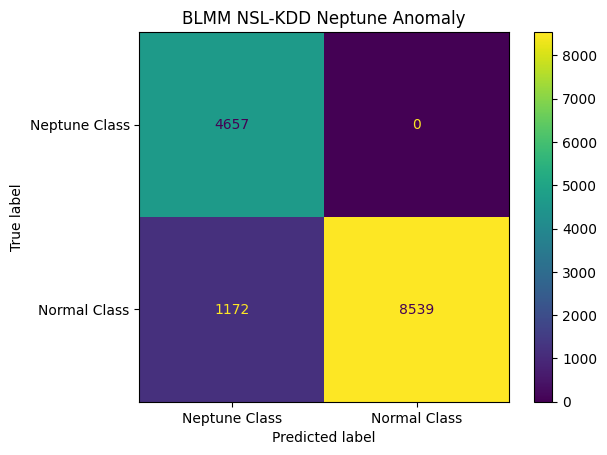

In [28]:
cm = confusion_matrix(labels, predictions_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Neptune Class', 'Normal Class'])
cm_display.plot()
cm_display.ax_.set_title('BLMM NSL-KDD Neptune Anomaly')
plt.show()